# Magnetostatic 2D non-linear

## Setup

### Path setup

In [1]:
import os

In [2]:
path_to_this_folder = os.getcwd() # Do it before calling %cd ../.. so that the path is accurate

### Project setup

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"   # Prevent internal ngsolve imports from killing the kernel


### Imports

Usual libraries

In [4]:
import tomllib
from time import time
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

from ngsolve import Mesh, H1, BilinearForm, LinearForm, GridFunction, dx, grad, InnerProduct, Integrate, CF, exp



Custom code

In [5]:
from neurom_optim.Pre_processing.process_hardware import get_precision, get_device
from neurom_optim.Pre_processing.process_gmsh import read_gmsh, get_nodes_and_elements_IDs
from neurom_optim.FENN.VertexNN.FEENN_2D.FEENN import FEENN_2D
from neurom_optim.FENN.VertexNN.FEENN_2D.Element import Tri_2D_lin
from neurom_optim.FENN.VertexNN.FEENN_2D.Mapping import Mapping_2D_Affine
from neurom_optim.FENN.ConstantNN.constantNN import ConstantNN
from neurom_optim.FENN.L2NN.field_L2NN import Field_L2NN
from neurom_optim.PropertiesNN.PropertiesNN import PropertiesNN
from neurom_optim.Pre_processing.build_solver import build_solver
from neurom_optim.PDE.optim_2D import Optim_2D_loss
from neurom_optim.PDE.operators import curl
from neurom_optim.PDE.magnetostatic_2D import Magnetostatic_2D
from neurom_optim.MaterialNN.BinarySelection import BinarySelection
from neurom_optim.Baselines.Poisson_2D.Uniform.baseline import baseline
from neurom_optim.Post_processing.VTKExport.export_vtk import export_vtk
from neurom_optim.MaterialNN.NL_nu_altair import NL_nu_altair
from neurom_optim.PDE.magnetostatic_2D_NL import Magnetostatic_2D_NL

from neurom_optim.Baselines.Magnetostatic_2D.NL.inductance_ngsolve import meshInductance, solve



### Number precision

In [6]:
IntPrecision = torch.int32
FloatPrecision = torch.float64
# FloatPrecision = torch.float32

### Hardware

Note that for cases of small meshes cpu outperforms gpu

In [7]:
device = 'cpu'
# device = 'mps'

# Problem description and problem-related variables definition

$$
\begin{align*}
        \;&\text{Find }&&\overrightarrow{A}^* =\arg\min_{\overrightarrow{A}\in H\left(\overrightarrow{\text{rot}},\Omega\right)}\int_\Omega \frac{1}{2\mu(x, \overrightarrow{\text{curl}}(\overrightarrow{A}))}\cdot\overrightarrow{\text{curl}}\left(\overrightarrow{A}\right)\cdot\overrightarrow{\text{curl}}\left(\overrightarrow{A}\right)-\overrightarrow{j}\cdot\overrightarrow{A}\text{d}\Omega\\\\
        &\text{s.t}&&\overrightarrow{A}(x^+)\cdot \overrightarrow{e}_z=A_0\\
        &&&\overrightarrow{A}(x^-)\cdot \overrightarrow{e}_z = -A_0\\
        &&&\overrightarrow{A}(x) = \overrightarrow{0}&\forall x\in\partial \Omega\\
        &&&\mu(x) = \mu_0(\overrightarrow{\text{curl}}(\overrightarrow{A}))&\forall x\in \Omega \backslash \Omega^+\bigcup\Omega^-\\
        &&&\mu(x) = \mu_1(\overrightarrow{\text{curl}}(\overrightarrow{A}))&\forall x\in\Omega^+\bigcup\Omega^-\\
        &&&\overrightarrow{j}(x) = \overrightarrow{0}&\forall x\in \Omega\\
        
    \end{align*}
$$

$$
\nu_i(\overrightarrow{\text{curl}}(\overrightarrow{A})) = \nu_{i_0}+K_i\exp\left\{k_i\cdot \overrightarrow{\text{curl}}(\overrightarrow{A})\cdot \overrightarrow{\text{curl}}(\overrightarrow{A})\right\}
$$

$\Omega$ is defined through a .msh file

In [8]:
# path_to_msh = os.path.join(path_to_this_folder, "Coil.msh")
# path_to_msh = os.path.join(path_to_this_folder, "Coil_fine.msh")
# path_to_msh = os.path.join(path_to_this_folder, "Coil_interm.msh")
path_to_msh = os.path.join(path_to_this_folder, "Coil_TC.msh")

$\mu$ can have two values $\mu_0$ or $\mu_1$ depending on the location in $\Omega$.  
For conveniency 
- we use $\nu = \frac{1}{\mu}$
- we enforce the switch between $\nu_0$ and $\nu_1$ through a choice field $p:\Omega\to\{0,1\}$ such that
$$
\nu(x) = (1-p(x))\nu_0 +p(x)\nu_1
$$

In [9]:
nu_0_value = 1/(4*np.pi*1e-7)
# nu_0_value = 1

nu_10_value = nu_0_value*100 
K_1_value = nu_0_value*10 
k_1_value = 1.8 



In [10]:
mur0 = 8000
Jsat = 2
a = 0.0003

# mur0 = 8000
# Jsat = 2
# a = 0.99

No source term because $\overrightarrow{j} = \overrightarrow{0}$ in $\Omega$.

The problem is set in 2D

In [11]:
interior_dim = 2
boundary_dim = 1

$\overrightarrow{A}$ is a vector field that can be represented as a scalar field carried by $\overrightarrow{e}_z$. Hence only one component is necessary to identify $\overrightarrow{A}$.

In [12]:
n_components = 1

dirichlet_exterior = {'entity_name'         : 'Exterior',
                        'Value'              : 0}

dirichlet_positive_source = {'entity_name'                       : 'Positive_source',
                            'entity_dim'                         : 0,
                            'Value'                              : 1/100 }

dirichlet_negative_source = {'entity_name'                       : 'Negative_source',
                            'entity_dim'                         : 0,
                            'Value'                              : -1/100}

dirichlet_config = [dirichlet_exterior, dirichlet_positive_source, dirichlet_negative_source]

We use a linear interpolation for our FEM representation of $V$. Therefore $\overrightarrow{\text{curl}}(\overrightarrow{A})$ is constant by element and the appropriate integration scheme is an order 1 gaussian quadrature.

In [13]:
quadrature_order = 1

# Baseline with NGSolve

Solve the problem with NGSolve to get a baseline.

Fore more info, see : https://docu.ngsolve.org/latest/

Build the mesh using the utils in src.Baselines.Magnetostatic_2D.NL.inductance_ngsolve

In [14]:
baseline_mesh = meshInductance(meshsize_factor = 0.5)

Define a solver using the utils in src.Baselines.Magnetostatic_2D.NL.inductance_ngsolve

In [15]:
def solveMagnetostatics(a0 : GridFunction,
                        nu : callable = lambda b : 1/(4e-7 * np.pi),
                        solver : str = "sparsecholesky"):
    
    """ Solve the magnetostatic problem """

    R = CF(((0,1),(-1,0)), dims = (2,2))
    Curl = lambda x : R * grad(x)

    residual = lambda u, v : Curl(v) * (nu(Curl(u)) * Curl(u)) * dx
    result = solve(a0.space, residual, initial_guess = a0, solver = solver)
    return result

Define the considered problem

In [16]:
B_avg = 1
# l = (Integrate(1, baseline_mesh)**(0.5))/3
# phi = 1*l


fes = H1(baseline_mesh, order=1, dirichlet = "out", dirichlet_bbnd = 'xP|xM')
a0 = GridFunction(fes)
# a0.vec.data[0] = phi/2
# a0.vec.data[1] = -phi/2

a0.vec.data[0] = dirichlet_positive_source['Value']
a0.vec.data[1] = dirichlet_negative_source['Value']

def nuIron(b):
    b2 = b**2 + 1e-10
    return 100. + 10. * exp(1.8*b2)

def myNu(b):
    mu0 = 4e-7 * np.pi
    return  baseline_mesh.MaterialCF({"core" : nuIron(b)}, default = 1/mu0)

Sove the problem with NGSolve

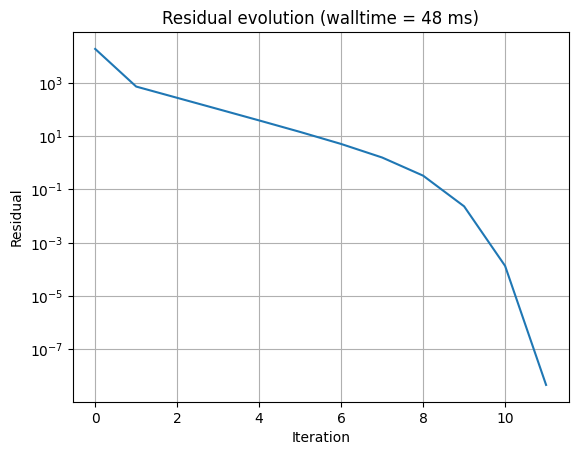

In [17]:
dicoSol = solveMagnetostatics(a0, nu = myNu)
baseline = dicoSol["solution"]

plt.semilogy(dicoSol["residual"])
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.title(f'Residual evolution (walltime = {1000 * dicoSol["wall_time"]:.0f} ms)')
plt.grid()
plt.show()

# FENN solve

Read the gmsh file and get the mesh related info

In [18]:
gmsh_mesh = read_gmsh(path_to_msh = path_to_msh,
                      IntPrecision = IntPrecision,
                      FloatPrecision = FloatPrecision)

Nodes = gmsh_mesh.nodes
connectivity = gmsh_mesh.elements[str(interior_dim)]['connectivity']

Processing GMSH file: 100%|██████████| 7984/7984 [00:00<00:00, 578554.67it/s]


Build a field candidate

In [19]:
# Build the field candidate. Here we use a linear interpolation scheme.
A = FEENN_2D(Nodes = Nodes,
            connectivity=connectivity,
            n_components=1,
            element=Tri_2D_lin(IntPrecision=IntPrecision, FloatPrecision=FloatPrecision),
            mapping = Mapping_2D_Affine(),
            IntPrecision=IntPrecision,
            FloatPrecision=FloatPrecision)

# Apply dirichlet
for dirichlet in dirichlet_config:

    nodeIDs, _ = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim = dirichlet.get('entity_dim', 1),
                                            entity_name = dirichlet.get('entity_name', None),
                                            entity_tag = dirichlet.get('entity_tag', None))
    
    
    value = dirichlet['Value']*torch.ones_like(nodeIDs, dtype = FloatPrecision).unsqueeze(-1)

    A.SetBCs(Fixed_nodal_coordinates_Ids = nodeIDs,
            Fixed_nodal_values_Ids = nodeIDs,
            Fixed_nodal_values_values = value)
    

# Specify the integration scheme
A.SetQuad(quadrature_order = quadrature_order)
A.Freeze(freeze_grid=True, freeze_interpolation=False)

# Move the object to the chosen hardware
A.to(device)

# Specify that A should store its evolution so that we can export it to vtk
A.StoreResults()

/Users/daby/Documents/Code/Stage_ARIA/neurom_optim/FENN/VertexNN/FEENN_2D/FEENN.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('connectivity', torch.tensor(connectivity, dtype = self.ref_int.dtype))


Define the material.

In [20]:
# Define the nu_0 property
# nu_0 = NL_nu(nu_0 = nu_00_value, 
#             K = K_0_value, 
#             k = k_0_value,
#             IntPrecision = IntPrecision,
#             FloatPrecision = FloatPrecision)

# Define the nu_0 property
nu_0 = ConstantNN(property_value=nu_0_value,
                    IntPrecision = IntPrecision,
                    FloatPrecision = FloatPrecision)

# nu_0 is not a field to be found
nu_0.setBCs(is_fixed=True)

# Define the nu_1 property
# nu_1 = NL_nu(nu_0 = nu_10_value, 
#             K = K_1_value, 
#             k = k_1_value,
#             IntPrecision = IntPrecision,
#             FloatPrecision = FloatPrecision)

nu_1 = NL_nu_altair(mur0 = mur0,
                    Jsat = Jsat,
                    a = a,
                    IntPrecision = IntPrecision,
                    FloatPrecision = FloatPrecision)

# nu_1 is not a field to be found
nu_1.setBCs(is_fixed=True)

# Define the nu property using nu_0 and nu_1
# BinarySelection.forward(el_ids, NPoints, *args, **kwargs) -> (1-choice)*self.properties['property_1'](el_ids, NPoints, *args, **kwargs) + choice*self.properties['property_2'](el_ids, NPoints, *args, **kwargs)
nu = BinarySelection(property_1     = nu_0,
                    property_2     = nu_1,
                    NElem          = len(connectivity),
                    IntPrecision   = IntPrecision,
                    FloatPrecision = FloatPrecision)


# Set the value of nu to nu_0 in "domain_no_coil"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'domain_no_coil')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.zeros_like(elemIDs))

# Set the value of nu to nu_0 in "coil_1"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'coil_1')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.zeros_like(elemIDs))

# Set the value of nu to nu_0 in "coil_2"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'coil_2')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.zeros_like(elemIDs))


# Set the value of nu to nu_1 in "core"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'core')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.ones_like(elemIDs))

# The only problem-relevant material property is nu
Mat = PropertiesNN(dim = interior_dim,
                NElem = len(connectivity),
                IntPrecision = IntPrecision,
                FloatPrecision = FloatPrecision)

Mat.add_property(property_name = 'nu',
                property = nu)

# Move the object to the chosen hardware
Mat.to(device)

PropertiesNN(
  (properties): ModuleDict(
    (nu): BinarySelection(
      (soft_choice): ParameterDict(
          (free): Parameter containing: [torch.DoubleTensor of size 0]
          (imposed): Parameter containing: [torch.DoubleTensor of size 5172]
      )
      (properties): ModuleDict(
        (property_1): ConstantNN()
        (property_2): NL_nu_altair(
          (mur0): ConstantNN()
          (Jsat): ConstantNN()
          (a): ConstantNN()
        )
      )
      (sigmoid): Sigmoid()
    )
  )
)

Define the objective function and how the fields of interest should be saved

In [21]:
vtk_export_config = {'path_to_folder'       : os.path.join(os.path.join(path_to_this_folder, 'Results'), 'VTK_exports'),
                    'cell_data'             : ['B', 'potential', 'j', 'field_term', 'source_term', 'nu', 'mapping_det'],
                    'point_data'            : ['A'],
                    'export_vtk'            : True}

energy_functionnal = Magnetostatic_2D_NL(IntPrecision=IntPrecision, 
                                        FloatPrecision=FloatPrecision,
                                        vtk_export = vtk_export_config,
                                        baseline = baseline, 
                                        baseline_mesh=baseline_mesh
                                        )

Specify the solver and build it. Here, the objective is convex so LBFGS (quasi-Newton) is appropriate.

In [22]:
solver_config = {'optimizer'               :  'lbfgs',
            'n_epochs'                :  500,
            'loss_decrease_c'         :   1e-13,
            'freeze_grid'             :   True,
            'freeze_interpolation'    :   False,
            'freeze_Mat'              :   True}

solver = build_solver(solver_config = solver_config,
                      loss = energy_functionnal,
                      model = A,
                      Mat = Mat)

solver.solve()

Solving (worse case scenario):  12%|█▏        | 62/500 [00:07<00:32, 13.66it/s, time=7.39] 

Export the loss

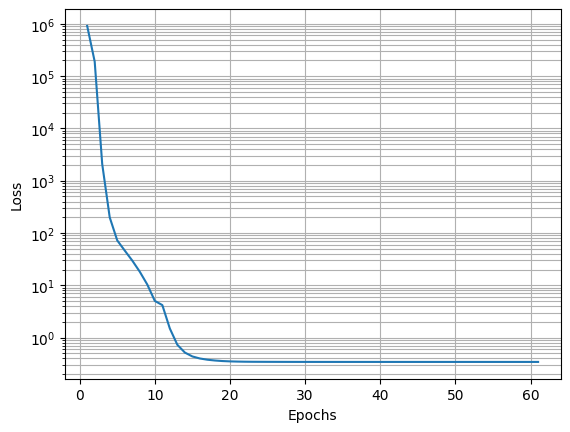

In [23]:
epochs, loss = solver.get_metric()

# Define the path to the main plot save folder
save_folder = os.path.join(os.path.join(path_to_this_folder, 'Results'), 'Plots')
os.makedirs(save_folder, exist_ok=True)

# Plot and save the loss evolution
save_name = f"loss.png"
save_path = os.path.join(save_folder, save_name)
plt.clf()
plt.plot(epochs, loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, which='both')
plt.savefig(save_path)

In [24]:
import plotly.graph_objects as go
import os

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=epochs, 
    y=loss, 
    mode='lines', 
    name='Training Loss'
))

fig.update_layout(
    title="Loss Evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    yaxis_type="log",  
    template="plotly_white",  
    hovermode="x unified", 
    width=700,   
    height=600,  
    yaxis=dict(
        tickformat=".2e",      
        exponentformat="e",    
        dtick = 1,
        # showexponent="all"     
        minor=dict(
            showgrid=True,          
            gridwidth=0.8,          # Slightly thinner 
            # gridcolor='WhiteSmoke', 
            tickmode="auto"         
        )
    )
    
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Save the plot (saving as html keeps it interactive) 
save_name = "loss.html"
save_path = os.path.join(save_folder, save_name)
fig.write_html(save_path)

Optional: fig.show()

In [25]:
print(f"Mat.properties['nu'].properties['property_2'].mur0.property\t:\n\n{Mat.properties['nu'].properties['property_2'].mur0.property}")
print(f"Mat.properties['nu'].properties['property_2'].Jsat.property\t:\n\n{Mat.properties['nu'].properties['property_2'].Jsat.property}")
print(f"Mat.properties['nu'].properties['property_2'].a.property\t:\n\n{Mat.properties['nu'].properties['property_2'].a.property}")


Mat.properties['nu'].properties['property_2'].mur0.property	:

Parameter containing:
tensor(8000., dtype=torch.float64)
Mat.properties['nu'].properties['property_2'].Jsat.property	:

Parameter containing:
tensor(2., dtype=torch.float64)
Mat.properties['nu'].properties['property_2'].a.property	:

Parameter containing:
tensor(0.0003, dtype=torch.float64)


Solving (worse case scenario):  12%|█▏        | 62/500 [00:19<00:32, 13.66it/s, time=7.39]

See the results in the VTK file